In [2]:
# make / read array
import numpy as np
import open3d as o3d

cmd_pcd = o3d.io.read_point_cloud("/home/travis_s/repos/3d/plyworker/rgb2.png-pointCloud.ply")
old_pcd = o3d.io.read_point_cloud('/home/travis_s/repos/3d/plyworker/data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0.ply')


In [8]:
import numpy as np
from PIL import Image
import imageio
import OpenEXR
import struct
import os

def get_pointcloud(color_image,depth_image,camera_intrinsics):
    """ creates 3D point cloud of rgb images by taking depth information

        input : color image: numpy array[h,w,c], dtype= uint8
                depth image: numpy array[h,w] values of all channels will be same

        output : camera_points, color_points - both of shape(no. of pixels, 3)
    """

    image_height = depth_image.shape[0]
    image_width = depth_image.shape[1]
    pixel_x,pixel_y = np.meshgrid(np.linspace(0,image_width-1,image_width),
                                  np.linspace(0,image_height-1,image_height))
    camera_points_x = np.multiply(pixel_x-camera_intrinsics[0,2],depth_image/camera_intrinsics[0,0])
    camera_points_y = np.multiply(pixel_y-camera_intrinsics[1,2],depth_image/camera_intrinsics[1,1])
    camera_points_z = depth_image
    camera_points = np.array([camera_points_x,camera_points_y,camera_points_z]).transpose(1,2,0).reshape(-1,3)

    color_points = color_image.reshape(-1,3)

    # Remove invalid 3D points (where depth == 0)
    valid_depth_ind = np.where(depth_image.flatten() > 0)[0]
    camera_points = camera_points[valid_depth_ind,:]
    color_points = color_points[valid_depth_ind,:]

    return camera_points,color_points

def write_pointcloud(filename,xyz_points,rgb_points=None):

    """ creates a .pkl file of the point clouds generated

    """

    assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
    if rgb_points is None:
        rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
    assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array and have same size as input XYZ points'

    # Write header of .ply file
    fid = open(filename,'wb')
    fid.write(bytes('ply\n', 'utf-8'))
    fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
    fid.write(bytes('property float x\n', 'utf-8'))
    fid.write(bytes('property float y\n', 'utf-8'))
    fid.write(bytes('property float z\n', 'utf-8'))
    fid.write(bytes('property uchar red\n', 'utf-8'))
    fid.write(bytes('property uchar green\n', 'utf-8'))
    fid.write(bytes('property uchar blue\n', 'utf-8'))
    fid.write(bytes('end_header\n', 'utf-8'))

    # Write 3D points to .ply file
    for i in range(xyz_points.shape[0]):
               fid.write(bytearray(struct.pack("fffccc",xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
                                        rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
                                        rgb_points[i,2].tostring())))
    fid.close()






In [9]:

    
# Run png to ply using iterative parameters
# subprocess.run['python3', 'create_pointCloud.py', '--rgb_filename', 'data/rgb_nathan.png', '--depth_filename data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png', '--output_directory', '.', '--fx', f'{p[0]}', '--fy', f'{p[1]}', '--cx', f'{p[2]}', '--cy', f'{p[3]}']
p = [100,100,100,100]
color_data = imageio.imread('data/rgb_nathan.png')
# color_data = np.asarray(im_color, dtype = "uint8")

if os.path.splitext(os.path.basename('data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png'))[1] == '.npy':
    depth_data = np.load(args.depth_filename)
else:
    im_depth = imageio.imread('data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png')
    depth_data = im_depth # values of all channels are equal


# camera_intrinsics  = [[fx 0 cx],
#                       [0 fy cy],
#                       [0 0 1]]
camera_intrinsics  = np.asarray([[p[0], 0, p[2]], [0, p[1], p[3]], [0, 0, 1]])



# filename = os.path.basename(args.rgb_filename)[:9] + '-pointCloud.ply'
# output_filename = os.path.join(args.output_directory, filename)

# print("Creating the point Cloud file at : ", output_filename )
camera_points, color_points = get_pointcloud(color_data, depth_data, camera_intrinsics)

print(camera_points)

[[  -32.     -32.      32.  ]
 [  -31.68   -32.      32.  ]
 [  -31.36   -32.      32.  ]
 ...
 [ 2556.84 29125.8    132.  ]
 [ 2344.98 26698.65   121.  ]
 [ 2637.04 30008.4    136.  ]]


In [3]:
import subprocess
import emcee
import numpy as np
import open3d as o3d
import numpy as np
from PIL import Image
import imageio
import OpenEXR
import struct
import os
# -------------------------------------------------------------------------------------------------------------------
# png -> ply functions

def get_pointcloud(color_image,depth_image,camera_intrinsics):
    """ creates 3D point cloud of rgb images by taking depth information

        input : color image: numpy array[h,w,c], dtype= uint8
                depth image: numpy array[h,w] values of all channels will be same

        output : camera_points, color_points - both of shape(no. of pixels, 3)
    """

    image_height = depth_image.shape[0]
    image_width = depth_image.shape[1]
    pixel_x,pixel_y = np.meshgrid(np.linspace(0,image_width-1,image_width),
                                  np.linspace(0,image_height-1,image_height))
    camera_points_x = np.multiply(pixel_x-camera_intrinsics[0,2],depth_image/camera_intrinsics[0,0])
    camera_points_y = np.multiply(pixel_y-camera_intrinsics[1,2],depth_image/camera_intrinsics[1,1])
    camera_points_z = depth_image
    camera_points = np.array([camera_points_x,camera_points_y,camera_points_z]).transpose(1,2,0).reshape(-1,3)

    color_points = color_image.reshape(-1,3)

    # Remove invalid 3D points (where depth == 0)
    valid_depth_ind = np.where(depth_image.flatten() > 0)[0]
    camera_points = camera_points[valid_depth_ind,:]
    color_points = color_points[valid_depth_ind,:]

    return camera_points,color_points

def write_pointcloud(filename,xyz_points,rgb_points=None):

    """ creates a .pkl file of the point clouds generated

    """

    assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
    if rgb_points is None:
        rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
    assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array and have same size as input XYZ points'

    # Write header of .ply file
    fid = open(filename,'wb')
    fid.write(bytes('ply\n', 'utf-8'))
    fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
    fid.write(bytes('property float x\n', 'utf-8'))
    fid.write(bytes('property float y\n', 'utf-8'))
    fid.write(bytes('property float z\n', 'utf-8'))
    fid.write(bytes('property uchar red\n', 'utf-8'))
    fid.write(bytes('property uchar green\n', 'utf-8'))
    fid.write(bytes('property uchar blue\n', 'utf-8'))
    fid.write(bytes('end_header\n', 'utf-8'))

    # Write 3D points to .ply file
    for i in range(xyz_points.shape[0]):
               fid.write(bytearray(struct.pack("fffccc",xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
                                        rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
                                        rgb_points[i,2].tostring())))
    fid.close()
# -----------------------------------------------------------------------------------------------------------------


#MCMC functions


def lnprior(p):
    return 0

# def lnlike(p,xdata, ydata):
def lnlike(p):
    # Run png to ply using iterative parameters
    camera_intrinsics  = np.asarray([[p[0], 0, p[2]], [0, p[1], p[3]], [0, 0, 1]])
    cmd_array, color_points = get_pointcloud(color_data, depth_data, camera_intrinsics)

    # # read in results of png to ply
    # cmd_pcd = o3d.io.read_point_cloud('rgb_natha-pointCloud.ply')
    # cmd_array = np.asarray(cmd_pcd.points)

    # move the first point to (0, 0, z)
    cmd_transform = [-cmd_array[0][0], -cmd_array[0][1], 0]
    cmd_normalized_array = cmd_array + cmd_transform

    # Convert it to pcd to do evaluation of fitness
    cmd_normalized_pcd = o3d.geometry.PointCloud()
    cmd_normalized_pcd.points = o3d.utility.Vector3dVector(cmd_normalized_array)

    
    # evaluate and return fitness
    evaluation = o3d.pipelines.registration.evaluate_registration(
        cmd_normalized_pcd,
        plyworker_normalized_pcd,
        threshold)
    return evaluation.fitness

# def lnprob(p):
#     lp = lnprior(p)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike(p)

def lnprob(p):
    return lnlike(p)


# --------------------------------------------------------------------------------------------------------------------------
# Reading in files


# Read in plyworker file that the first point has been moved to (0,0,z)
plyworker_normalized_pcd = o3d.io.read_point_cloud('plyworker_normalized.ply')

color_data = imageio.imread('data/rgb_nathan.png')
# color_data = np.asarray(im_color, dtype = "uint8")

if os.path.splitext(os.path.basename('data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png'))[1] == '.npy':
    depth_data = np.load(args.depth_filename)
else:
    im_depth = imageio.imread('data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png')
    depth_data = im_depth # values of all channels are equal

# ---------------------------------------------------------------------------------------------------------------------------------
# Running MCMC

threshold = 1
ndim, nwalkers, nsteps = 4,8, 2

initial_pos_fx = [np.random.uniform(0,1000) for i in range(nwalkers)]
initial_pos_fy = [np.random.uniform(0,1000) for i in range(nwalkers)]
initial_pos_cx = [np.random.uniform(0,1000) for i in range(nwalkers)]
initial_pos_cy = [np.random.uniform(0,1000) for i in range(nwalkers)]

pos = np.column_stack((initial_pos_fx, initial_pos_fy, initial_pos_cx, initial_pos_cy))


# xdata = np.asarray(commandline_pointcloud.points)
# ydata = np.asarray(plyworker_normalized_pcd.points)
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata))

print('Running')

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=())
# sampler.run_mcmc(pos, nsteps, progress=True)


import time
from multiprocessing import Pool, cpu_count
import os

os.environ["OMP_NUM_THREADS"] = str(cpu_count()-1)


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=())
sampler.run_mcmc(pos, nsteps, progress=True)




# with Pool() as pool:
#     sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(), pool = pool)
#     start = time.time()
#     print('test')
#     for pos, lnp, rstate in tqdm(sampler.run_mcmc(pos, nsteps, progress=True)):
#         pass
#     end = time.time()
#     multi_time = end - start
#     print("Multiprocessing took {0:.1f} seconds".format(multi_time))
#     print("{0:.1f} times faster than serial".format(serial_time / multi_time))
#     Pool.close()



Running
100%|██████████| 2/2 [22:22<00:00, 671.25s/it]


State([[  433.2444659   -512.73506887  -132.48908951    14.01341205]
 [ 1236.65383606  1772.63533502  1179.63022312  1387.80208457]
 [  378.50026586   239.63616496   -14.40563553   349.0150419 ]
 [   46.62871713   591.39671715   423.35977828   158.35761773]
 [  433.41246841   546.26231973  1365.38596246   691.91528225]
 [ -327.96860971 -1019.32063238  1309.22629444  -708.31974612]
 [  940.49646128   188.07993896    50.73246465   466.77807075]
 [  371.86259785  -532.55687498  -829.18867323  -803.42290942]], log_prob=[0. 0. 0. 0. 0. 0. 0. 0.], blobs=None, random_state=('MT19937', array([3650336194, 1486526416, 2056663639, 4224926790, 4206618629,
        545624736, 3352090418,  562797745, 4174532883, 3342016190,
       1564604775,  204316191,  447928011, 2349001376,  512744822,
        717803586, 2104047055, 2903827817, 1532895208,  180024079,
       2513450062, 1698853840, 3383852152,  718751386, 3055209836,
       1528477280, 3601026290,   80962966, 1078202205,  133799803,
       298731

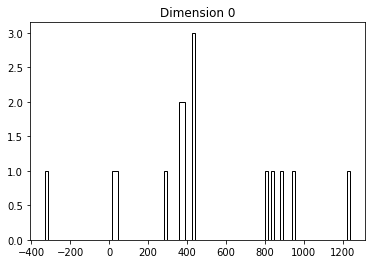

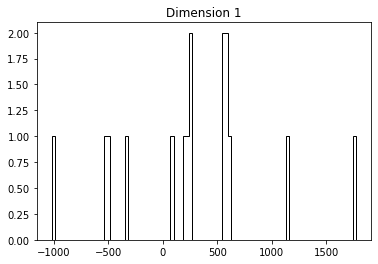

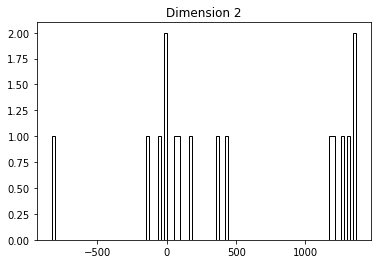

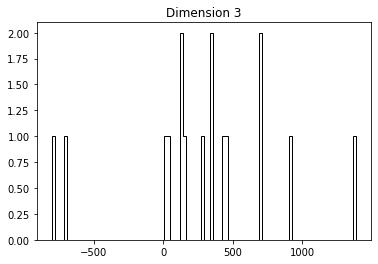

In [5]:
import matplotlib.pyplot as pl

for i in range(ndim):
    pl.figure()
    pl.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    pl.title("Dimension {0:d}".format(i))

pl.show()

In [18]:
# saving progress
import subprocess
import emcee
import numpy as np
import open3d as o3d
import numpy as np
from PIL import Image
import imageio
import OpenEXR
import struct
import os
# -------------------------------------------------------------------------------------------------------------------
# png -> ply functions

def get_pointcloud(color_image,depth_image,camera_intrinsics):
    """ creates 3D point cloud of rgb images by taking depth information

        input : color image: numpy array[h,w,c], dtype= uint8
                depth image: numpy array[h,w] values of all channels will be same

        output : camera_points, color_points - both of shape(no. of pixels, 3)
    """

    image_height = depth_image.shape[0]
    image_width = depth_image.shape[1]
    pixel_x,pixel_y = np.meshgrid(np.linspace(0,image_width-1,image_width),
                                  np.linspace(0,image_height-1,image_height))
    camera_points_x = np.multiply(pixel_x-camera_intrinsics[0,2],depth_image/camera_intrinsics[0,0])
    camera_points_y = np.multiply(pixel_y-camera_intrinsics[1,2],depth_image/camera_intrinsics[1,1])
    camera_points_z = depth_image
    camera_points = np.array([camera_points_x,camera_points_y,camera_points_z]).transpose(1,2,0).reshape(-1,3)

    color_points = color_image.reshape(-1,3)

    # Remove invalid 3D points (where depth == 0)
    valid_depth_ind = np.where(depth_image.flatten() > 0)[0]
    camera_points = camera_points[valid_depth_ind,:]
    color_points = color_points[valid_depth_ind,:]

    return camera_points,color_points

def write_pointcloud(filename,xyz_points,rgb_points=None):

    """ creates a .pkl file of the point clouds generated

    """

    assert xyz_points.shape[1] == 3,'Input XYZ points should be Nx3 float array'
    if rgb_points is None:
        rgb_points = np.ones(xyz_points.shape).astype(np.uint8)*255
    assert xyz_points.shape == rgb_points.shape,'Input RGB colors should be Nx3 float array and have same size as input XYZ points'

    # Write header of .ply file
    fid = open(filename,'wb')
    fid.write(bytes('ply\n', 'utf-8'))
    fid.write(bytes('format binary_little_endian 1.0\n', 'utf-8'))
    fid.write(bytes('element vertex %d\n'%xyz_points.shape[0], 'utf-8'))
    fid.write(bytes('property float x\n', 'utf-8'))
    fid.write(bytes('property float y\n', 'utf-8'))
    fid.write(bytes('property float z\n', 'utf-8'))
    fid.write(bytes('property uchar red\n', 'utf-8'))
    fid.write(bytes('property uchar green\n', 'utf-8'))
    fid.write(bytes('property uchar blue\n', 'utf-8'))
    fid.write(bytes('end_header\n', 'utf-8'))

    # Write 3D points to .ply file
    for i in range(xyz_points.shape[0]):
               fid.write(bytearray(struct.pack("fffccc",xyz_points[i,0],xyz_points[i,1],xyz_points[i,2],
                                        rgb_points[i,0].tostring(),rgb_points[i,1].tostring(),
                                        rgb_points[i,2].tostring())))
    fid.close()
# -----------------------------------------------------------------------------------------------------------------


#MCMC functions


def lnprior(p):
    return 0

# def lnlike(p,xdata, ydata):
def lnlike(p):
    # Run png to ply using iterative parameters
    camera_intrinsics  = np.asarray([[p[0], 0, p[2]], [0, p[1], p[3]], [0, 0, 1]])
    cmd_array, color_points = get_pointcloud(color_data, depth_data, camera_intrinsics)

    # # read in results of png to ply
    # cmd_pcd = o3d.io.read_point_cloud('rgb_natha-pointCloud.ply')
    # cmd_array = np.asarray(cmd_pcd.points)

    # move the first point to (0, 0, z)
    cmd_transform = [-cmd_array[0][0], -cmd_array[0][1], 0]
    cmd_normalized_array = cmd_array + cmd_transform

    # Convert it to pcd to do evaluation of fitness
    cmd_normalized_pcd = o3d.geometry.PointCloud()
    cmd_normalized_pcd.points = o3d.utility.Vector3dVector(cmd_normalized_array)

    
    # evaluate and return fitness
    evaluation = o3d.pipelines.registration.evaluate_registration(
        cmd_normalized_pcd,
        plyworker_normalized_pcd,
        threshold)
    return evaluation.fitness

# def lnprob(p):
#     lp = lnprior(p)
#     if not np.isfinite(lp):
#         return -np.inf
#     return lp + lnlike(p)

def lnprob(p):
    return lnlike(p)


# --------------------------------------------------------------------------------------------------------------------------
# Reading in files


# Read in plyworker file that the first point has been moved to (0,0,z)
plyworker_normalized_pcd = o3d.io.read_point_cloud('plyworker_normalized.ply')

color_data = imageio.imread('data/rgb_nathan.png')
# color_data = np.asarray(im_color, dtype = "uint8")

if os.path.splitext(os.path.basename('data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png'))[1] == '.npy':
    depth_data = np.load(args.depth_filename)
else:
    im_depth = imageio.imread('data/3eac62bd-d6db-401f-8bba-38cd5bb3ec18__Top-heading-west_0_g.png')
    depth_data = im_depth # values of all channels are equal

# ---------------------------------------------------------------------------------------------------------------------------------
# Running MCMC

threshold = 1
ndim, nwalkers, nsteps = 4,8, 2

initial_pos_fx = [np.random.uniform(0,1000) for i in range(nwalkers)]
initial_pos_fy = [np.random.uniform(0,1000) for i in range(nwalkers)]
initial_pos_cx = [np.random.uniform(0,1000) for i in range(nwalkers)]
initial_pos_cy = [np.random.uniform(0,1000) for i in range(nwalkers)]

pos = np.column_stack((initial_pos_fx, initial_pos_fy, initial_pos_cx, initial_pos_cy))


# xdata = np.asarray(commandline_pointcloud.points)
# ydata = np.asarray(plyworker_normalized_pcd.points)
#sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata))

print('Running')

# sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=())
# sampler.run_mcmc(pos, nsteps, progress=True)


import time
from multiprocessing import Pool, cpu_count
import os

os.environ["OMP_NUM_THREADS"] = str(cpu_count()-1)

# Set up the backend
# Don't forget to clear it in case the file already exists
filename = "plyworker_vals.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(), backend=backend)


max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.run_mcmc(pos, nsteps, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

Running
100%|██████████| 2/2 [22:54<00:00, 687.28s/it]


In [21]:
tau

array([nan, nan, nan, nan])

In [20]:
import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)

labels = list(map(r"$\theta_{{{0}}}$".format, range(1, ndim + 1)))
labels += ["log prob", "log prior"]

corner.corner(all_samples, labels=labels);

/home/travis_s/anaconda3/envs/general/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]


ValueError: cannot convert float NaN to integer